In [3]:
import numpy as np
from scipy import spatial

from matplotlib.mlab import griddata

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
#sfrom astroplan.plots import plot_sky

images = "images/"

In [4]:
from astroplan import download_IERS_A
download_IERS_A()

ImportError: dlopen(/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload/gdbm.so, 2): Symbol not found: _gdbm_errno
  Referenced from: /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload/gdbm.so
  Expected in: /usr/local/opt/gdbm/lib/libgdbm.4.dylib
 in /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload/gdbm.so

## Let`s  import the data from txt to numpy  array

In [5]:
file1 = "20130202.txt"
file2 = "20130921.txt"

def name_to_time(file1):
    time = file1[:4]+"-"+file1[4:6]+"-"+file1[6:8]
    return time 

def readtxt(fname):
    with open(fname) as f:
        content = f.read().splitlines()
        a = []
        for i in content:
            a.append(i.split())
        
    return [a[0],np.asarray(a[1:]).astype("float")]
content1 = readtxt(file1)
dataE    = content1[0]
data1    = content1[1]

## Processing and AltAz transform the  data

In [6]:
### file handling

def get_groups(data1):    
    obj1RA = data1[:,:3]
    obj1DC = data1[:,3:6]
    tel1RA = data1[:,6:9]
    tel1DC = data1[:,9:12]
    time1  = data1[:,12:14]
    return obj1RA,obj1DC,tel1RA,tel1DC,time1 
def to_string(data): ### convert coordinate arrays to string
    string = []
    for i in data:
        string.append(str(int(i[0]))+":"+str(int(i[1]))+":"+str(i[2]))
    return string

def time_string(data):
    string = []
    for i in data:
        string.append(str(int(i[0]))+":"+str(int(i[1])))
    return string

def string_to_list(a):
    obj1RA,obj1DC,tel1RA,tel1DC, time1 = a
    a = to_string(obj1RA)
    b = to_string(obj1DC)
    c = to_string(tel1RA)
    d = to_string(tel1DC)
    t = time_string(time1)
    return a,b,c,d,t

def make_time_list(file1, t1):
    time = []
    date = name_to_time(file1)
    for i in t1:
        time.append(date+" "+i)
    return np.asarray(time)

############# Coordinate trafos

def get_harima_AltAZ(file1):    
    content1 = readtxt(file1)
    dataE    = content1[0]
    data1    = content1[1]
    harima   = EarthLocation(lat=+35.0253*u.deg, lon=+134.3356*u.deg, height=449*u.m)
    utcoffset= 0*u.hour
    
    O1RS, O1DS, T1RS, T1DS, t1 = string_to_list(get_groups(data1))
    O1     = SkyCoord(O1RS,O1DS,  unit=(u.hourangle, u.deg) )
    T1     = SkyCoord(T1RS,T1DS,  unit=(u.hourangle, u.deg) )
    Time1  = Time(make_time_list(file1, t1))
    O1_alt = O1.transform_to(AltAz(obstime=Time1+utcoffset,location=harima))
    T1_alt = T1.transform_to(AltAz(obstime=Time1+utcoffset,location=harima))
    
    return O1_alt, T1_alt

def get_AzEl(file0):

    ALTAZ1 = get_harima_AltAZ(file0)
    
    objects1 = ALTAZ1[0]
    correct1 = ALTAZ1[1]
    
    OAZ1, OEL1 = objects1.az.deg, objects1.alt.deg
    CAZ1, CEL1 = correct1.az.deg, correct1.alt.deg
    return [OAZ1, OEL1, CAZ1, CEL1]

def get_eqtime(t1):
    t11 = []
    for i in t1: 
        t11.append(i+":00"+" 00:00:00")
    t11 = np.asarray(t11)
    t2 = SkyCoord(t11,  unit=(u.hourangle, u.deg) )
    return t2

def eq_subt_time(radec,t1):
    t1   = get_eqtime(t1)
    hour = radec.ra.degree-t1.ra.degree
    dec  = radec.dec.degree
    new  = SkyCoord(hour, dec, unit=(u.deg, u.deg))
    return new
    
def format_eq(file1):  #### load equatorial coordinates
    content1 = readtxt(file1)
    dataE    = content1[0]
    data1    = content1[1]
    O1RS, O1DS, T1RS, T1DS, t1 = string_to_list(get_groups(data1))
    O1    = SkyCoord(O1RS,O1DS,  unit=(u.hourangle, u.deg) )
    T1    = SkyCoord(T1RS,T1DS,  unit=(u.hourangle, u.deg) )
    
    return O1,T1, t1

def get_local_from_eq(file0):
    content1 = readtxt(file0)
    dataE    = content1[0]
    O1,T1,t1 = format_eq(file0)
    O1C      = eq_subt_time(O1,t1)
    T1C      = eq_subt_time(T1,t1)
    return O1C, T1C

def x_center(x):
    for i in range(x.shape[0]):
        if x[i] > 180.:
            x[i] = x[i] -360.
    
    return x

In [7]:
a = np.array([1,183,350])
b = x_center(a.copy())

print a
print b

[  1 183 350]
[   1 -177  -10]


## Let` s plot that s@"*

### Equatorial 

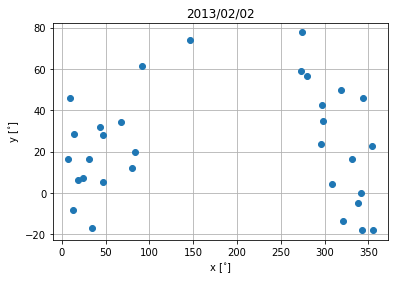

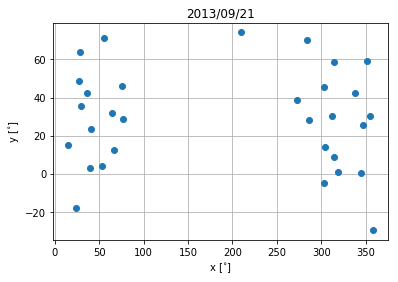

In [8]:
def overview_eq(file0):    
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    plt.plot(O1C.ra.degree,O1C.dec.degree, "o")
    
    
    plt.title(file0[:4]+"/"+file0[4:6]+"/"+file0[6:8])
    plt.xlabel(r"x [$^{\circ}$]")
    plt.ylabel(r"y [$^{\circ}$]")
    
    plt.grid()
    plt.savefig("images/"+file0[:-4]+"OV.pdf", transparent = True, bbox_inches='tight')
    plt.show()

overview_eq(file1)
overview_eq(file2)

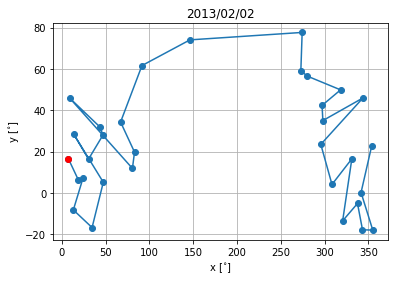

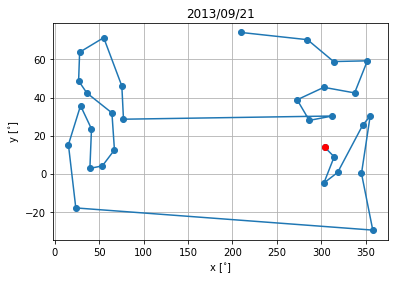

In [7]:
def overview_eq_line(file0):    
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    plt.plot(O1C.ra.degree,O1C.dec.degree, "-o")
    plt.plot(O1C.ra.degree[0],O1C.dec.degree[0], "or")
    
    plt.title(file0[:4]+"/"+file0[4:6]+"/"+file0[6:8])
    plt.xlabel(r"x [$^{\circ}$]")
    plt.ylabel(r"y [$^{\circ}$]")
    
    plt.grid()
    plt.savefig("images/"+file0[:-4]+"OVLine.pdf", transparent = True, bbox_inches='tight')
    plt.show()
overview_eq_line(file1)
overview_eq_line(file2)

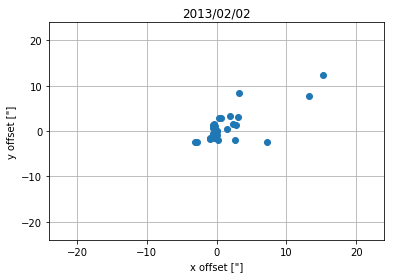

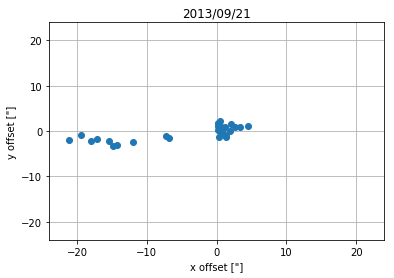

In [8]:
def offset_over_eq(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    xsub = O1C.ra.degree-T1C.ra.degree
    ysub = O1C.dec.degree-T1C.dec.degree
    
    ysub = ysub*60.
    xsub = xsub*60.
    
    plt.plot(xsub,ysub, "o")
    #plt.xlim([-abs(xsub.max())*1.1,abs(xsub.max())*1.1])
    #plt.ylim([-abs(ysub.max())*1.1,abs(ysub.max())*1.1])
    plt.xlim([-0.4*60.,0.4*60.])
    plt.ylim([-0.4*60.,0.4*60.])
    plt.xlabel("x offset [\"]")
    plt.ylabel("y offset [\"]")
    plt.title(file0[:4]+"/"+file0[4:6]+"/"+file0[6:8])
    plt.grid()
    plt.savefig("images/"+file0[:-4]+"offset.pdf", transparent = True, bbox_inches='tight')
    plt.show()
offset_over_eq(file1)
offset_over_eq(file2)

/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  six.iterkeys(self.codes))))


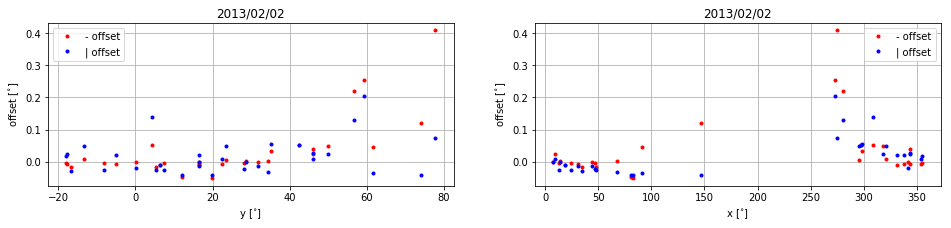

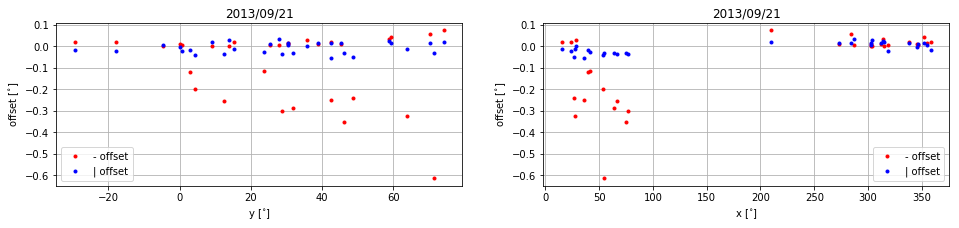

In [9]:
def overview_off_eq(file0):    
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    xsub = O1C.ra.degree-T1C.ra.degree
    ysub = O1C.dec.degree-T1C.dec.degree
    XY   = np.sqrt(xsub**2.+ysub**2.)
    
    fig = plt.figure(figsize=(16,3))
    ax  = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    
    ax.plot(O1C.dec.degree,xsub, ".r", label = "- offset")
    ax.plot(O1C.dec.degree,ysub, ".b", label = "| offset")
    ax.set_xlabel(r"y [$^{\circ}$]")
    ax.set_ylabel(r"offset [$^{\circ}$]")
    ax.legend(loc = "left")
    ax.grid()

    ax1.plot(O1C.ra.degree,xsub, ".r", label = "- offset")
    ax1.plot(O1C.ra.degree,ysub, ".b", label = "| offset")
    ax1.set_xlabel(r"x [$^{\circ}$]")
    ax1.set_ylabel(r"offset [$^{\circ}$]")
    ax1.grid()
    ax1.legend(loc = "left")
    ax.set_title(file0[:4]+"/"+file0[4:6]+"/"+file0[6:8])
    ax1.set_title(file0[:4]+"/"+file0[4:6]+"/"+file0[6:8])
    plt.savefig("images/"+file0[:-4]+"offsetREL.pdf", transparent = True, bbox_inches='tight')
    plt.show()
    
overview_off_eq(file1)
overview_off_eq(file2)

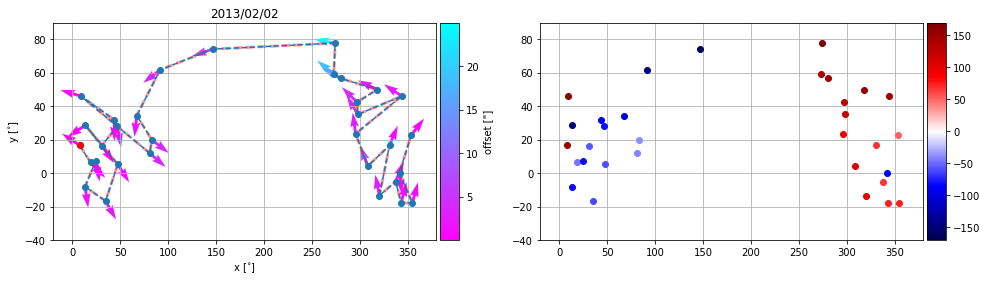

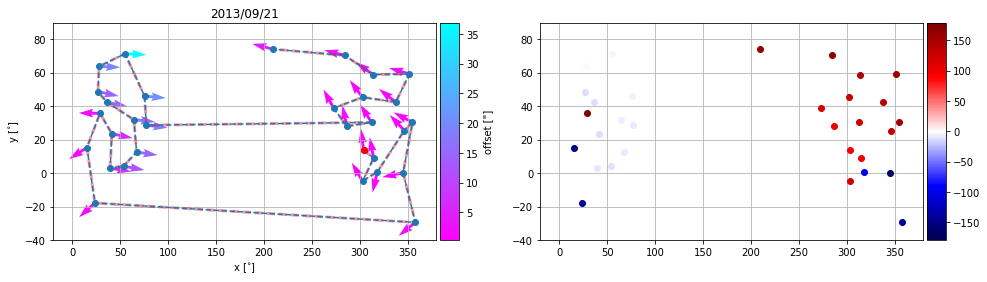

In [10]:
def colorscale(XY, c_m  = "cool_r"):
    norm = matplotlib.colors.Normalize(vmin=XY.min(),vmax=XY.max() )
    s_m  = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
    s_m.set_array([])
    return s_m

def colorscale_rad(XY,    c_m  = "seismic"):
    norm = matplotlib.colors.Normalize(vmin=-np.abs(XY).max(),vmax=np.abs(XY).max() )

    s_m  = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
    s_m.set_array([])
    return s_m

def overview_off_eq(file0): 
    
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    xsub = T1C.ra.degree-O1C.ra.degree
    ysub = O1C.dec.degree-T1C.dec.degree
    XY   = np.sqrt(xsub**2.+ysub**2.)*60.   ### offset amplitude
    AN   = np.arctan2(ysub,xsub)/np.pi*180.
    
    
    s_m = colorscale(XY)
    s_m2= colorscale_rad(AN)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,4), frameon = False)
    
    ax1.plot(O1C.ra.degree,O1C.dec.degree, "r--", linewidth = 3, alpha = 0.4)
    ax1.plot(O1C.ra.degree,O1C.dec.degree, "--o")
    ax1.plot(O1C.ra.degree[0],O1C.dec.degree[0], "or")
    for i in range(XY.shape[0]):
        
        ax1.quiver(O1C.ra.degree[i],O1C.dec.degree[i], xsub[i]*10.,ysub[i]*10. ,color=s_m.to_rgba(XY[i]))
        ax2.plot(O1C.ra.degree[i],O1C.dec.degree[i], "o"                 ,color=s_m2.to_rgba(AN[i]))
    
    cax1  = make_axes_locatable(ax1).append_axes("right", size="5%", pad=0.05)
    cax2  = make_axes_locatable(ax2).append_axes("right", size="5%", pad=0.05)
    cbar  = plt.colorbar(s_m,  cax= cax1)
    cbar2 = plt.colorbar(s_m2, cax= cax2)
    
    
    ax1.set_title(file0[:4]+"/"+file0[4:6]+"/"+file0[6:8])
    ax1.set_xlabel(r"x [$^{\circ}$]")
    ax1.set_ylabel(r"y [$^{\circ}$]")
    
    cbar.ax.set_ylabel("offset [\"]")
    
    ax1.set_xlim([-20,380])
    ax1.set_ylim([-40,90])
    ax2.set_xlim([-20,380])
    ax2.set_ylim([-40,90])
    
    ax1.grid()
    ax2.grid()
    plt.savefig("images/"+file0[:-4]+"OVofrot.pdf", transparent = True, bbox_inches='tight')
    plt.show()
overview_off_eq(file1)
overview_off_eq(file2)

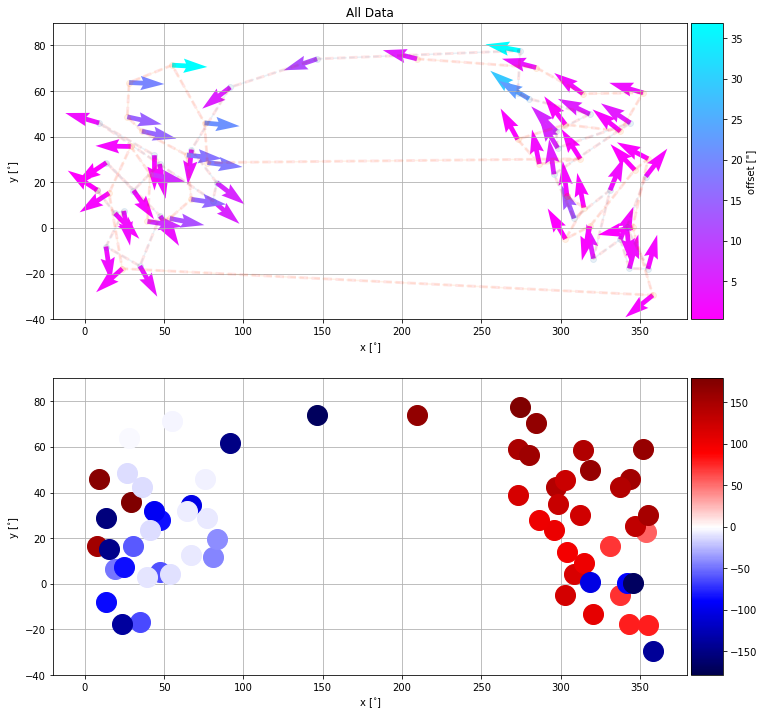

In [11]:
def overview_off_eq_2_fin(file0): 
    
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    xsub = T1C.ra.degree-O1C.ra.degree
    ysub = O1C.dec.degree-T1C.dec.degree
    XY   = np.sqrt(xsub**2.+ysub**2.)*60.   ### offset amplitude
    AN   = np.arctan2(ysub,xsub)/np.pi*180.
    
    
    s_m = colorscale(XY)
    s_m2= colorscale_rad(AN)
    
    ax1.plot(O1C.ra.degree,O1C.dec.degree, "r--", linewidth = 3, alpha = 0.1)
    ax1.plot(O1C.ra.degree,O1C.dec.degree, "--o", alpha = 0.1)
    ax1.plot(O1C.ra.degree[0],O1C.dec.degree[0], "or", alpha = 0.1)

    for i in range(XY.shape[0]):
        
        ax1.quiver(O1C.ra.degree[i],O1C.dec.degree[i], xsub[i]*10.,ysub[i]*10. ,color=s_m.to_rgba(XY[i]))
        ax2.plot(O1C.ra.degree[i],O1C.dec.degree[i], "o"  ,markersize = 20      ,color=s_m2.to_rgba(AN[i]))
    

    
    return s_m, s_m2
    
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,12), frameon = False)  

overview_off_eq_2_fin(file1)
s_m, s_m2 = overview_off_eq_2_fin(file2)

cax1  = make_axes_locatable(ax1).append_axes("right", size="5%", pad=0.05)
cax2  = make_axes_locatable(ax2).append_axes("right", size="5%", pad=0.05)
cbar  = plt.colorbar(s_m,  cax= cax1)
cbar2 = plt.colorbar(s_m2, cax= cax2)
    
    
ax1.set_title("All Data")
ax1.set_xlabel(r"x [$^{\circ}$]")
ax1.set_ylabel(r"y [$^{\circ}$]")
    
ax2.set_xlabel(r"x [$^{\circ}$]")
ax2.set_ylabel(r"y [$^{\circ}$]")
    
cbar.ax.set_ylabel("offset [\"]")
    
ax1.set_xlim([-20,380])
ax1.set_ylim([-40,90])
ax2.set_xlim([-20,380])
ax2.set_ylim([-40,90])


ax1.grid()
ax2.grid()
plt.savefig("images/both_OVofrot2.pdf", transparent = True, bbox_inches='tight')
plt.show()

## Interpolation

In [12]:
def conturstuff(x,y,z, ax, lab = "x offset", alpha = 1):
        # define grid.
        xi = np.linspace(x.min(),x.max(),100)
        yi = np.linspace(y.min(),y.max(),100)
        zi = griddata(x,y,z,xi,yi)
        # contour the gridded data, plotting dots at the randomly spaced data points.
        
        CS2 = ax.contourf(xi,yi,zi,1000,cmap=plt.cm.jet, alpha = alpha)
        CS  = ax.contour(  xi,yi,zi,20,linewidths=0.5 , colors='k', alpha = alpha )
        #plt.colorbar() # draw colorbar
        # plot data points.
        ax.scatter(x,y,marker='o',s=30,c='k', label= lab)
        
        cax1  = make_axes_locatable(ax).append_axes("right", size="2%", pad=0.05)
        cbar  = plt.colorbar(CS2, cax= cax1)
        ax.grid()
        return xi, yi, zi

(32,)
(32,)
(32,)


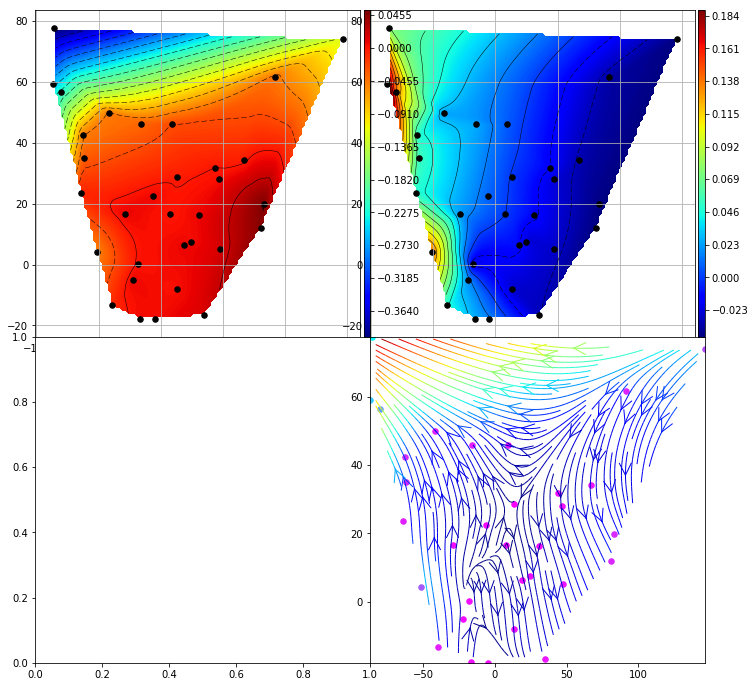

In [13]:

        
        
def interpol(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    x    = x_center(O1C.ra.degree)
    y    = O1C.dec.degree
    xsub = T1C.ra.degree-O1C.ra.degree
    ysub = O1C.dec.degree-T1C.dec.degree
    
    XY   = np.sqrt(xsub**2.+ysub**2.)*60.
    
    print x.shape
    print y.shape
    print xsub.shape
    
    fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize = (12,12), frameon = False) 


    
    xi1, yi1, zi1 = conturstuff(x,y,xsub, ax = ax1)
    xi2, yi2, zi2 = conturstuff(x,y,ysub, ax = ax2)
    
    ex = 1
    XX, YY = np.meshgrid(xi1[::ex],yi1[::ex])
    ZX, ZY = zi1[::ex,::ex], zi2[::ex,::ex]
    
    ax4.streamplot(XX, YY, ZX, ZY, 
                               color= np.sqrt(ZX**2 + ZY**2), 
                               linewidth=1, 
                               cmap=plt.cm.jet,
                               density=2, 
                               arrowstyle='->', 
                               arrowsize=3)
    
    sm = colorscale(XY)
    for i in range(XY.shape[0]):
        ax4.scatter(x[i],y[i],marker='o',s=30,c=sm.to_rgba(XY[i]))
    ax4.set_xlim([XX.min(),XX.max()])
    ax4.set_ylim([YY.min(),YY.max()])
    
    fig.subplots_adjust(hspace=0)
    fig.subplots_adjust(wspace=0)
    plt.savefig("images/"+file0[:-4]+"interpol.pdf", transparent = True, bbox_inches='tight')
    plt.show()
    
    
interpol(file1)

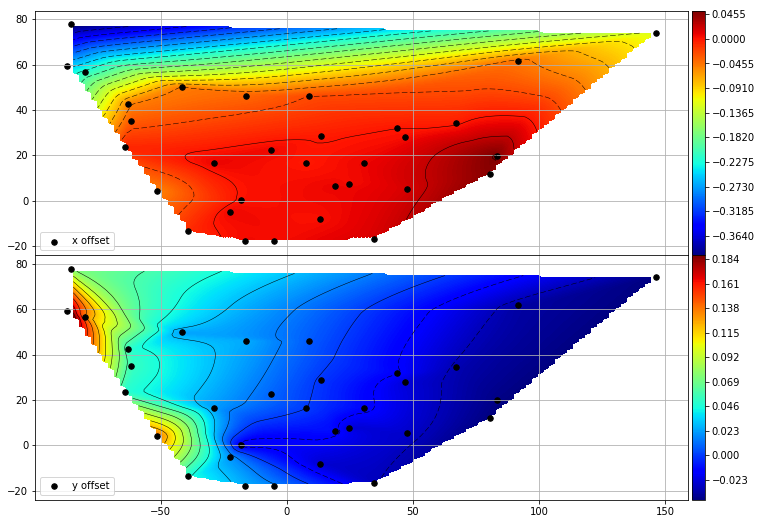

In [14]:
def xyz_cont(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    x, y, xsub, ysub    = x_center(O1C.ra.degree), O1C.dec.degree, T1C.ra.degree-O1C.ra.degree, O1C.dec.degree-T1C.dec.degree

    fig, (ax1,ax2) = plt.subplots(2,1, figsize = (12,9), frameon = False) 
    
    xi1, yi1, zi1 = conturstuff(x,y,xsub, ax = ax1)
    xi2, yi2, zi2 = conturstuff(x,y,ysub, ax = ax2, lab = "y offset")
    ax1.legend()
    ax2.legend()
    fig.subplots_adjust(hspace=0)
    fig.subplots_adjust(wspace=0)
    plt.savefig("images/"+file0[:-4]+"interpol0.pdf", transparent = True, bbox_inches='tight')
    plt.show()
    
xyz_cont(file1)

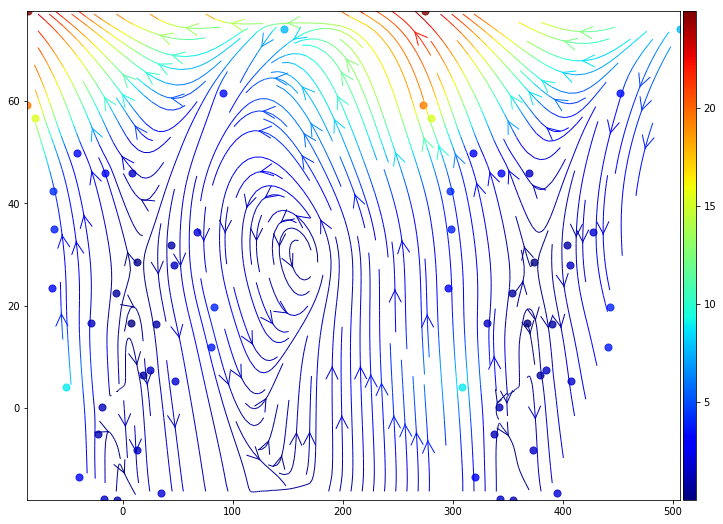

In [15]:
def xyz_arrow(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    x, y, xsub, ysub    = x_center(O1C.ra.degree), O1C.dec.degree, T1C.ra.degree-O1C.ra.degree, O1C.dec.degree-T1C.dec.degree
    
    def SStack(data, a = 0.):
        return np.hstack([data,data+a])
    
    x, y, xsub, ysub = SStack(x, 360.), SStack(y), SStack(xsub), SStack(ysub) 
    
    xi = np.linspace(x.min(),x.max(),100)
    yi = np.linspace(y.min(),y.max(),100)
    xsubi = griddata(x,y,xsub,xi,yi)
    ysubi = griddata(x,y,ysub,xi,yi)
    XY    = np.sqrt(xsub**2.+ysub**2.)*60.
    
    ex = 1
    XX, YY = np.meshgrid(xi[::ex],yi[::ex])
    ZX, ZY = xsubi[::ex,::ex], ysubi[::ex,::ex]

                               
    fig, ax = plt.subplots(1, figsize = (12,9), frameon = False)
    ARR     =ax.streamplot(XX, YY, ZX, ZY, 
                               color= np.sqrt(ZX**2 + ZY**2), 
                               linewidth=1, 
                               cmap=plt.cm.jet,
                               density=2, 
                               arrowstyle='->', 
                               arrowsize=3)
    sm = colorscale(XY, "jet")
    for i in range(XY.shape[0]):
        ax.scatter(x[i],y[i],marker='o',s=50,c=sm.to_rgba(XY[i]), alpha = 0.8)
        ax.set_xlim([XX.min(),XX.max()])
        ax.set_ylim([YY.min(),YY.max()])
    cax1  = make_axes_locatable(ax).append_axes("right", size="2%", pad=0.05)
    cbar  = plt.colorbar(sm, cax= cax1)
    plt.savefig("images/"+file0[:-4]+"interpol_arrow.pdf", transparent = True, bbox_inches='tight')
    plt.show()

xyz_arrow(file1)


## Extrapolate

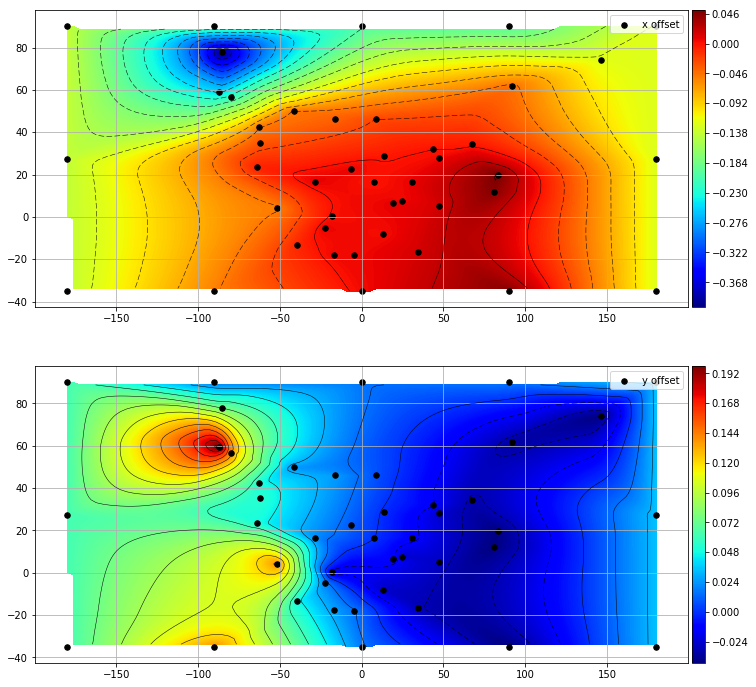

In [16]:
def extrapolate_180(x,y,xz,yz, lat_0=35.0253, max_el = 90.):
    nxy = np.array([[-180. ,-180.  ,-180., -90., -90.  , 0., 0.   , 90., 90.  , 180.  ,180. ,180.],
                    [-lat_0,(max_el-lat_0)/2.,90.  ,  90., -lat_0 ,90., -lat_0, 90., -lat_0, -lat_0,(max_el-lat_0)/2. ,90.]]).T  
      
    index = spatial.KDTree(np.vstack([x,y]).T).query(nxy)[1]
    
    X  = np.hstack([x , nxy[:,0]]) 
    Y  = np.hstack([y , nxy[:,1]]) 
    XZ = np.hstack([xz, xz[index]])
    YZ = np.hstack([yz, yz[index]])
    

    XZ[Y==90.]  = XZ[Y==90.].mean()
    YZ[Y==90.]  = YZ[Y==90.].mean()
    XZ[X==180.] = (XZ[X==180.].mean()+XZ[X==-180.].mean())/2.
    YZ[X==180.] = (YZ[X==180.].mean()+YZ[X==-180.].mean())/2.
    XZ[X==-180.] = (XZ[X==180.].mean()+XZ[X==-180.].mean())/2.
    YZ[X==-180.] = (YZ[X==180.].mean()+YZ[X==-180.].mean())/2.
    return X, Y, XZ, YZ
    
    
def xyz_cont_ex(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    xf,yf,xsf, ysf   = x_center(O1C.ra.degree), O1C.dec.degree, T1C.ra.degree-O1C.ra.degree, O1C.dec.degree-T1C.dec.degree

    x, y, xsub, ysub = extrapolate_180(xf,yf,xsf, ysf)

    fig, (ax1,ax2) = plt.subplots(2,1, figsize = (12,12), frameon = False) 
    
    xi1, yi1, zi1 = conturstuff(x,y,xsub, ax = ax1, alpha = 1)
    #conturstuff(xf,yf,xsf, ax = ax1)
    xi2, yi2, zi2 = conturstuff(x,y,ysub, ax = ax2, lab = "y offset", alpha = 1)
    #conturstuff(xf,yf,ysf, ax = ax2, lab = "y offset")
    
    ax1.legend()
    ax2.legend()
    #fig.subplots_adjust(hspace=0)
    fig.subplots_adjust(wspace=0)
    plt.savefig("images/"+file0[:-4]+"extrapol.pdf", transparent = True, bbox_inches='tight')
    plt.show()
    
xyz_cont_ex(file1)

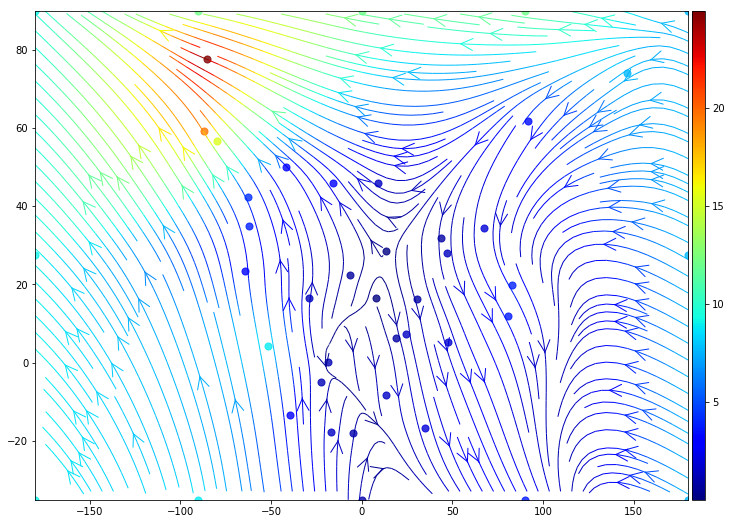

In [17]:
def xyz_arrow_ex(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    x, y, xsub, ysub    = x_center(O1C.ra.degree), O1C.dec.degree, T1C.ra.degree-O1C.ra.degree, O1C.dec.degree-T1C.dec.degree

    
    x, y, xsub, ysub = extrapolate_180(x, y, xsub, ysub)
    
    xi = np.linspace(x.min(),x.max(),100)
    yi = np.linspace(y.min(),y.max(),100)
    xsubi = griddata(x,y,xsub,xi,yi)
    ysubi = griddata(x,y,ysub,xi,yi)
    XY    = np.sqrt(xsub**2.+ysub**2.)*60.
    
    ex = 1
    XX, YY = np.meshgrid(xi[::ex],yi[::ex])
    ZX, ZY = xsubi[::ex,::ex], ysubi[::ex,::ex]

                               
    fig, ax = plt.subplots(1, figsize = (12,9), frameon = False)
    ARR     =ax.streamplot(XX, YY, ZX, ZY, 
                               color= np.sqrt(ZX**2 + ZY**2), 
                               linewidth=1, 
                               cmap=plt.cm.jet,
                               density=2, 
                               arrowstyle='->', 
                               arrowsize=3)
    sm = colorscale(XY, "jet")
    for i in range(XY.shape[0]):
        ax.scatter(x[i],y[i],marker='o',s=50,c=sm.to_rgba(XY[i]), alpha = 0.8)
        ax.set_xlim([XX.min(),XX.max()])
        ax.set_ylim([YY.min(),YY.max()])
    cax1  = make_axes_locatable(ax).append_axes("right", size="2%", pad=0.05)
    cbar  = plt.colorbar(sm, cax= cax1)
    plt.savefig("images/"+file0[:-4]+"extrapol_arrow.pdf", transparent = True, bbox_inches='tight')
    plt.show()

xyz_arrow_ex(file1)

# polar stuff

/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3266: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3275: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3228: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3237: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes doc

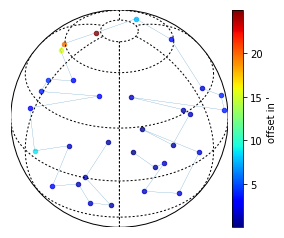

In [18]:
def xyz_cont_pol(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    x, y, xsub, ysub    = x_center(O1C.ra.degree), O1C.dec.degree, T1C.ra.degree-O1C.ra.degree, O1C.dec.degree-T1C.dec.degree
    
    XY    = np.sqrt(xsub**2.+ysub**2.)*60.
    
    m = Basemap(projection='ortho',lon_0=0,lat_0=35.0253,resolution='l')
    
    m.drawmeridians(np.arange(0.,420.,60.))
    m.drawparallels(np.arange(-90.,120.,30.))


    
    sm = colorscale(XY, "jet")
    xx, yy = m(x,y)
    m.plot(xx,yy, linewidth = 0.2)
    for i in range(XY.shape[0]):
        m.scatter(xx[i],yy[i],marker='o',s=20,c=sm.to_rgba(XY[i]), alpha = 0.8)
    
    cb = m.colorbar(sm,"right", size="5%", pad='2%')
    cb.ax.set_ylabel('offset in \'', rotation=90)
    plt.savefig("images/"+file0[:-4]+"points_sphere.pdf", transparent = True, bbox_inches='tight')
    plt.show()
xyz_cont_pol(file1)

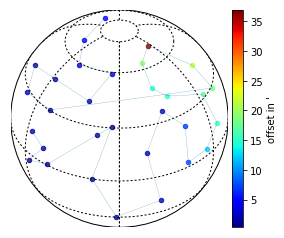

In [19]:
xyz_cont_pol(file2)

/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3622: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3691: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3519: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3586: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes doc

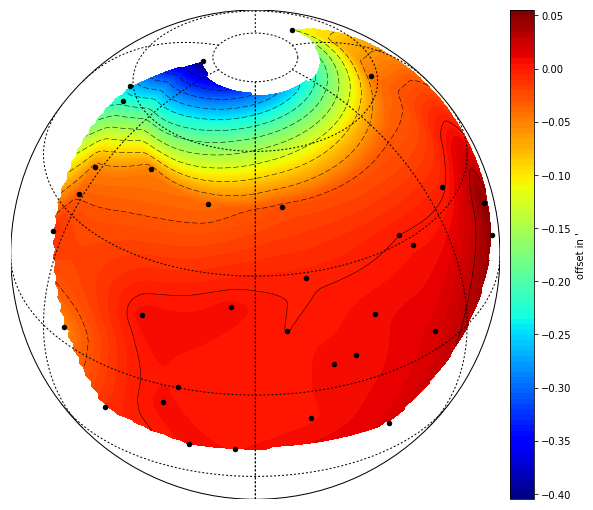

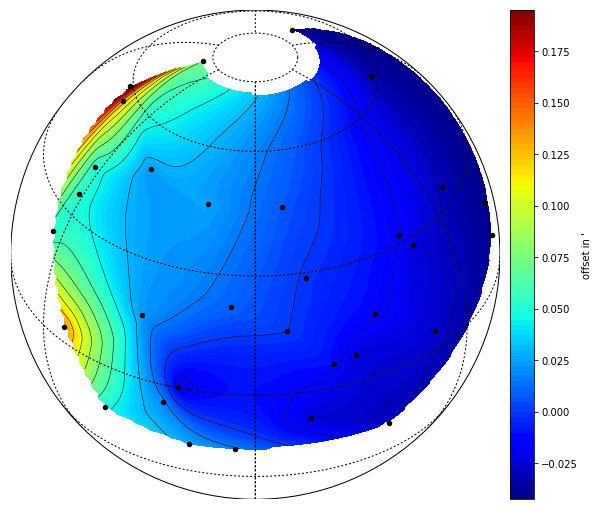

In [20]:
def xyz_cont_pol(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    x, y, xsub, ysub    = O1C.ra.degree, O1C.dec.degree, T1C.ra.degree-O1C.ra.degree, O1C.dec.degree-T1C.dec.degree
    x = x_center(x)
            
    XY = np.sqrt(xsub**2.+ysub**2.)*60.
    yi = np.linspace(-90,90,200)
    xi = np.linspace(-180,180,200)
    
    
    zi = griddata(x,y,xsub,xi,yi,interp = "nn")
    zy = griddata(x,y,ysub,xi,yi,interp = "nn")
        # contour the gridded data, plotting dots at the randomly spaced data points.
    
    
    m = Basemap(projection='ortho',lon_0=0,lat_0=35.0253,resolution='l')   
    
    
    Xii, Yii  = np.meshgrid(xi, yi)
    Xi , Yi   = m(Xii, Yii)
    
    Xj ,Yj    = m(x,y)
    
        
    ### plot for x 
    plt.figure(figsize=(12,9))
    CS2 = m.contourf(Xi, Yi, zi,100,cmap=plt.cm.jet)#,animated=True)
    CS  = m.contour( Xi, Yi, zi,15,linewidths=0.5,colors='k')#,animated=True)

    m.scatter(Xj,Yj,marker='o',s=20,c="k")
    
    cb  = m.colorbar(CS2,"right", size="5%", pad='2%')
    cb.ax.set_ylabel('offset in \'', rotation=90)

    m.drawmeridians(np.arange(0.,420.,60.))
    m.drawparallels(np.arange(-90.,120.,30.))
    plt.savefig("images/"+file0[:-4]+"interpol_sphere_x.pdf", transparent = True, bbox_inches='tight')
    plt.show()
    
    ### plot for y
    plt.figure(figsize=(12,9))
    CS2 = m.contourf(Xi, Yi, zy,100,cmap=plt.cm.jet)#,animated=True)
    CS  = m.contour( Xi, Yi, zy,15,linewidths=0.5,colors='k')#,animated=True)

    m.scatter(Xj,Yj,marker='o',s=20,c="k")
    
    cb  = m.colorbar(CS2,"right", size="5%", pad='2%')
    cb.ax.set_ylabel('offset in \'', rotation=90)

    m.drawmeridians(np.arange(0.,420.,60.))
    m.drawparallels(np.arange(-90.,120.,30.))
    plt.savefig("images/"+file0[:-4]+"interpol_sphere_y.pdf", transparent = True, bbox_inches='tight')
    plt.show()
    
xyz_cont_pol(file1)

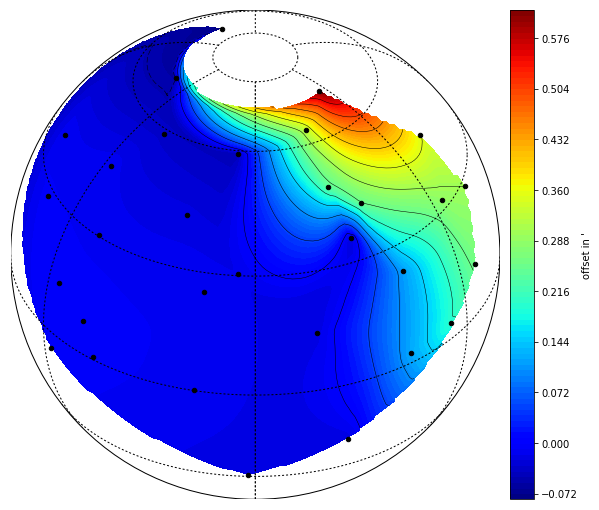

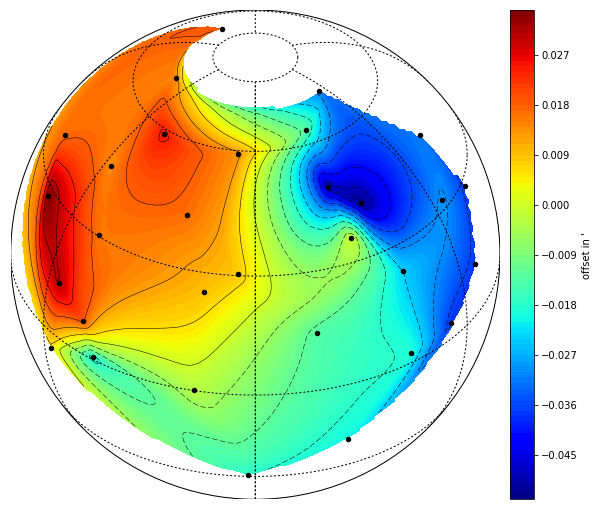

In [21]:
xyz_cont_pol(file2)

# Extrapolate

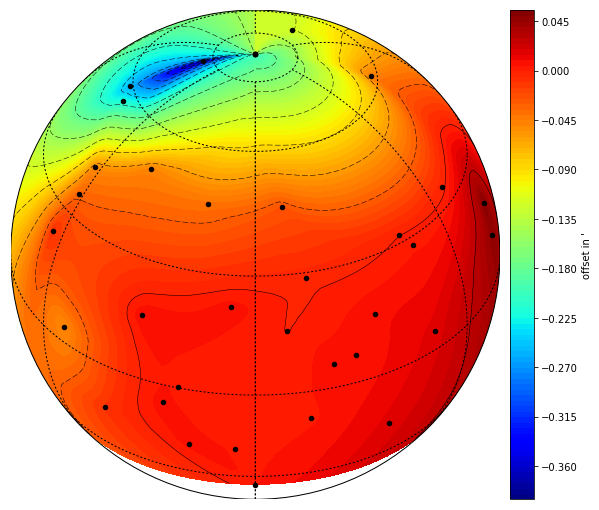

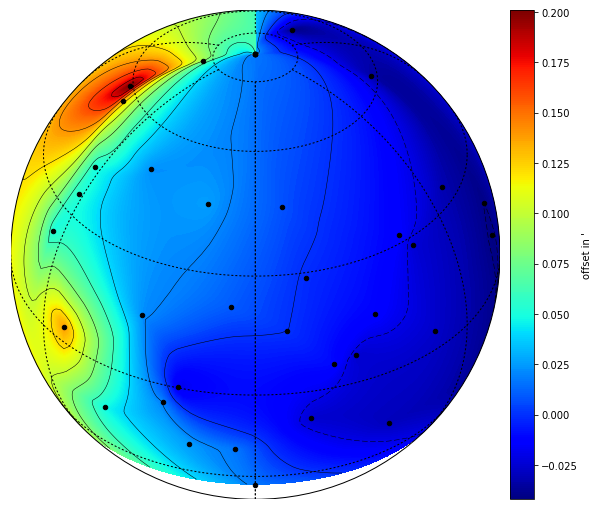

In [22]:
def xyz_cont_pol_EX(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    xf,yf,xsf, ysf   = x_center(O1C.ra.degree), O1C.dec.degree, T1C.ra.degree-O1C.ra.degree, O1C.dec.degree-T1C.dec.degree
    
    x, y, xsub, ysub = extrapolate_180(xf,yf,xsf, ysf)
    
    XY = np.sqrt(xsub**2.+ysub**2.)*60.
    yi = np.linspace(-90,90,200)
    xi = np.linspace(-180,180,200)
    
    
    zx = griddata(x,y,xsub,xi,yi,interp = "nn")
    zy = griddata(x,y,ysub,xi,yi,interp = "nn")
        # contour the gridded data, plotting dots at the randomly spaced data points.
    
    
    m = Basemap(projection='ortho',lon_0=0,lat_0=35.0253,resolution='l')   
    
    
    Xii, Yii  = np.meshgrid(xi, yi)
    Xi , Yi   = m(Xii, Yii)
    
    Xj ,Yj    = m(x,y)
    
        
    ### plot for x 
    plt.figure(figsize=(12,9))
    CS2 = m.contourf(Xi, Yi, zx,100,cmap=plt.cm.jet)#,animated=True)
    CS  = m.contour( Xi, Yi, zx,15,linewidths=0.5,colors='k')#,animated=True)

    m.scatter(Xj,Yj,marker='o',s=20,c="k")
    
    cb  = m.colorbar(CS2,"right"   , size="5%", pad='2%')
    cb.ax.set_ylabel('offset in \'', rotation=90)

    m.drawmeridians(np.arange(0.,420.,60.))
    m.drawparallels(np.arange(-90.,120.,30.))
    plt.savefig("images/"+file0[:-4]+"extrapol_sphere_x.pdf", transparent = True, bbox_inches='tight')
    plt.show()
    
    ### plot for y
    plt.figure(figsize=(12,9))
    CS2 = m.contourf(Xi, Yi, zy,256,cmap=plt.cm.jet)#,animated=True)
    CS  = m.contour( Xi, Yi, zy,15,linewidths=0.5,colors='k')#,animated=True)

    m.scatter(Xj,Yj,marker='o',s=20,c="k")
    
    cb  = m.colorbar(CS2,"right", size="5%", pad='2%')
    cb.ax.set_ylabel('offset in \'', rotation=90)

    m.drawmeridians(np.arange(0.,420.,60.))
    m.drawparallels(np.arange(-90.,120.,30.))
    plt.savefig("images/"+file0[:-4]+"extrapol_sphere_y.pdf", transparent = True, bbox_inches='tight')
    plt.show()
    
xyz_cont_pol_EX(file1)

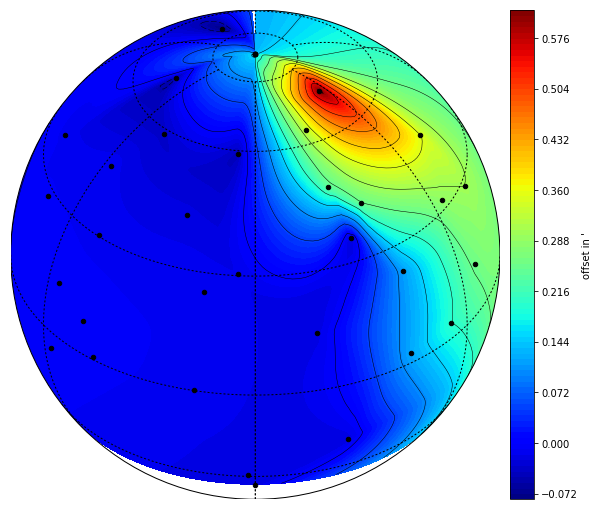

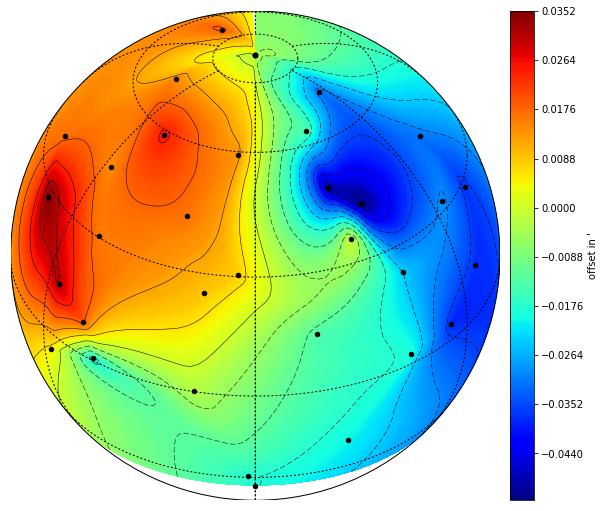

In [23]:
xyz_cont_pol_EX(file2)

In [24]:
def xyz_arrow_pol(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    x, y, xsub, ysub    = O1C.ra.degree, O1C.dec.degree, T1C.ra.degree, T1C.dec.degree
    x    = x_center(x)
    xsub = x_center(xsub)    
    XY = np.sqrt(xsub**2.+ysub**2.)*60.
    yi = np.linspace(-90 ,90 ,100)
    xi = np.linspace(-180,180,100)
    
    
    zix = griddata(x,y,xsub,xi,yi,interp = "nn")
    ziy = griddata(x,y,ysub,xi,yi,interp = "nn")
        # contour the gridded data, plotting dots at the randomly spaced data points.
    
    plt.figure(figsize=(12,9))
    m = Basemap(projection='ortho',lon_0=10,lat_0=35.0253,resolution='l')   
    
    
    Xii, Yii  = np.meshgrid(xi, yi)
    Xi , Yi   = m(Xii, Yii)
    
    Xzi, Yzi  = np.meshgrid(zix, ziy)
    ZXX, ZYY   = m(Xzi, Yzi)
    
    
    Xj ,Yj    = m(x,y)    
    
    
    plt.figure(figsize=(12,9))
    m.streamplot(Xi , Yi, ZXX, ZYY, latlon=True)
    #                           color= np.sqrt(ZX**2 + ZY**2), 
     #                          linewidth=1, 
      #                         cmap=plt.cm.jet,
       #                        density=2, 
        #                       arrowstyle='->', 
         #                      arrowsize=3)
    
    m.scatter(Xj,Yj,marker='o',s=20,c="k")
    
    
    #cb  = m.colorbar(CS2,"right", size="5%", pad='2%')
    #cb.ax.set_ylabel('offset in \'', rotation=90)


    m.drawmeridians(np.arange(0.,420.,60.))
    m.drawparallels(np.arange(-90.,120.,30.))
    
    
    plt.show()

#xyz_arrow_pol(file1)

/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3721: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3730: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


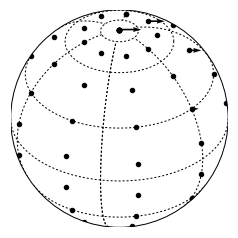

In [25]:
y = np.linspace(-90 ,90 ,10)
x = np.linspace(-180,180,10)



m = Basemap(projection='ortho',lon_0=10,lat_0=35.0253,resolution='l')  


Xi, Yi  = np.meshgrid(x, y)
xi ,yi    = m(Xi, Yi)





#a,b,c,d = m.transform_vector(x+25,y+25,x,y)

m.scatter(xi,yi,marker='o',s=20,c="k")
m.quiver( x ,y ,x*40 ,y*0, latlon=True)

m.drawmeridians(np.arange(0.,420.,60.))
m.drawparallels(np.arange(-90.,120.,30.))
    
plt.show()

## Statistics

In [26]:
def print_stat(file0):
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    x    = O1C.ra.degree
    y    = O1C.dec.degree
    xz   = T1C.ra.degree-O1C.ra.degree
    yz   = O1C.dec.degree-T1C.dec.degree
    
    MP   = x.shape[0]
    MEX  = np.abs(xz).mean()*60.
    STX  = np.abs(xz).std()*60.
    MEY  = np.abs(yz).mean()*60.
    STY  = np.abs(yz).std()*60.
    
    Xmin, Xmax = np.abs(xz).min()*60., np.abs(xz).max()*60.
    Ymin, Ymax = np.abs(yz).min()*60., np.abs(yz).max()*60.
    
    print "Number of Points: "+str(MP)
    print "mean X/Y -offset: "+str(MEX)[:3]+"\" "+str(MEY)[:3]+"\""
    print "std  X/Y -offset: "+str(STX)[:3]+"\" "+str(STY)[:3]+"\""
    
    print "min  X/Y -offset: "+str(Xmin)[:3]+"\" "+str(Ymin)[:3]+"\""
    print "max  X/Y -offset: "+str(Xmax)[:3]+"\" "+str(Ymax)[:3]+"\""
    
print_stat(file1)    

Number of Points: 32
mean X/Y -offset: 2.8" 2.3"
std  X/Y -offset: 5.2" 2.5"
min  X/Y -offset: 0.0" 0.0"
max  X/Y -offset: 24." 12."


In [27]:
print_stat(file2) 

Number of Points: 31
mean X/Y -offset: 6.7" 1.3"
std  X/Y -offset: 8.7" 0.7"
min  X/Y -offset: 0.1" 0.0"
max  X/Y -offset: 36." 3.1"


### Polar

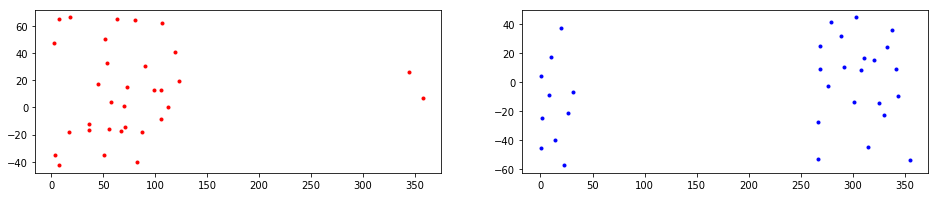

In [28]:
def plot_location(file1,file2):
    OAZ1, OEL1, CAZ1, CEL1 = get_AzEl(file1)
    OAZ2, OEL2, CAZ2, CEL2 = get_AzEl(file2)
    fig = plt.figure(figsize=(16,3))
    ax  = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    ax.plot(OAZ1, OEL1, "r.")
    ax1.plot(OAZ2, OEL2, "b.")
    
    plt.show()
    
plot_location(file1,file2)

## let`s plot the offset positions for each messurement

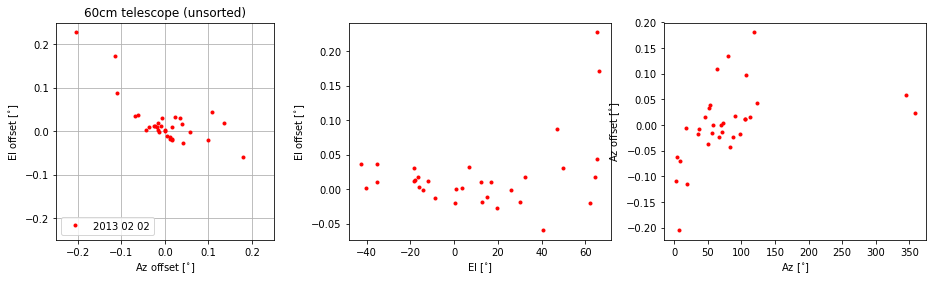

In [29]:
def make_offset_plot(file1):
    
    ALTAZ1 = get_harima_AltAZ(file1)
    
    objects1 = ALTAZ1[0]
    correct1 = ALTAZ1[1]
    
    OAZ1, OEL1 = objects1.az.deg, objects1.alt.deg
    CAZ1, CEL1 = correct1.az.deg, correct1.alt.deg
    
    
    ####### compute the pointing offset for each target
    Azoffset = CAZ1-OAZ1
    Eloffset = CEL1-OEL1
    
    
    ###### plot pointing offset
    fig = plt.figure(figsize=(16,4))
    ax  = fig.add_subplot(131)
    ax.plot(Azoffset, Eloffset, "r.", label = file1[:4]+" "+file1[4:6]+" "+file1[6:8])
    ax.set_xlim([-abs(Azoffset).max()*1.1,abs(Azoffset).max()*1.1])
    ax.set_ylim([-abs(Eloffset).max()*1.1,abs(Eloffset).max()*1.1])
    ax.set_xlim([-0.25,0.25])
    ax.set_ylim([-0.25,0.25])            
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(r"Az offset [$^{\circ}$]")
    ax.set_ylabel(r"El offset [$^{\circ}$]")
    ax.set_title("60cm telescope (unsorted)")
    ax.legend(loc = "lower left")
    ax.grid()
    
    
    ###### plot pointing El offset depending on the El
    ax1  = fig.add_subplot(132)
    ax1.plot(OEL1, Eloffset, "r.")
    
    ax1.set_xlabel(r"El [$^{\circ}$]")
    ax1.set_ylabel(r"El offset [$^{\circ}$]")
    
    
    ###### plot pointing Az offset depending on the Az
    ax2  = fig.add_subplot(133)
    ax2.plot(OAZ1, Azoffset, "r.")
    ax2.set_xlabel(r"Az [$^{\circ}$]")
    ax2.set_ylabel(r"Az offset [$^{\circ}$]") 

    plt.show()
    
make_offset_plot(file1)

# Get Offset

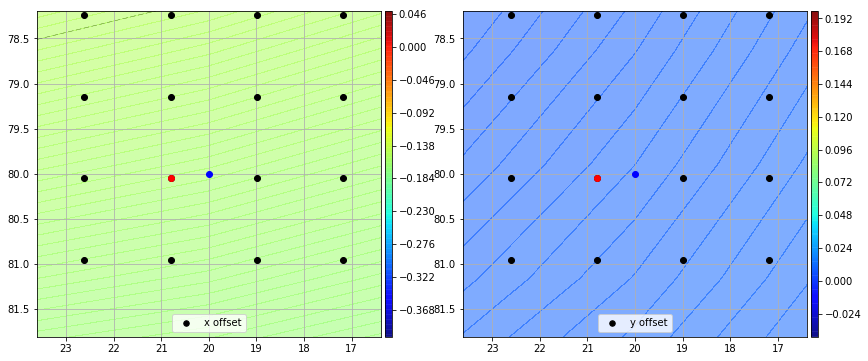

-0.163964634656
0.0125872966521


In [30]:

def get_offset(file0, xp = 20., yp = 80.):
    
      
    
    O1C, T1C = get_local_from_eq(file0) ### gets local static eq telescope coordinates 
    xf,yf,xsf, ysf   = x_center(O1C.ra.degree), O1C.dec.degree, T1C.ra.degree-O1C.ra.degree, O1C.dec.degree-T1C.dec.degree
    
    x, y, xsub, ysub = extrapolate_180(xf,yf,xsf, ysf)
    
    XY = np.sqrt(xsub**2.+ysub**2.)*60.
    yi = np.linspace(-90,90,200)
    xi = np.linspace(-180,180,200)
    
    
    zx = griddata(x,y,xsub,xi,yi,interp = "nn")
    zy = griddata(x,y,ysub,xi,yi,interp = "nn")
    
    
    X, Y = np.meshgrid(xi,yi)
    
     
    
    # Lets find the closest closest index  
    #index = np.unravel_index(spatial.KDTree(np.vstack([X.ravel(),Y.ravel()]).T).query([xp,yp])[1], X.shape) ## maybe slower
    
    
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx
    
    index = (find_nearest(yi,yp),find_nearest(xi,xp))

    
    
    fig, (ax,ay) = plt.subplots(1,2, figsize = (14,6), frameon = False)
    
    a = 2
    xmin, xmax = xp-a*(xi[0]-xi[1]), xp+a*(xi[0]-xi[1])
    ymin, ymax = yp-a*(yi[0]-yi[1]),yp+a*(yi[0]-yi[1])
    
    
    def do_plot(ax = ax):
        ax.plot(X,Y, "ok")
        ax.plot(X[index], Y[index], "or")
        ax.plot(xp, yp, "ob")
        
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
    
    do_plot(ax = ax)
    do_plot(ax = ay)
    
    conturstuff(x,y,xsub, ax = ax, lab = "x offset", alpha = 0.5)
    conturstuff(x,y,ysub, ax = ay, lab = "y offset", alpha = 0.5)
    
    ax.legend()
    ay.legend()
    plt.savefig("images/"+file0[:-4]+"offcomp.pdf", transparent = True, bbox_inches='tight')
    plt.show()
    
    return zx[index], zy[index]
    
zx, zy = get_offset(file1)
print zx
print zy